In [1]:
import matplotlib.pyplot as plt

In [2]:
import math
import numpy as np
import pandas as pd
from tqdm.notebook import trange, tqdm
from sklearn.model_selection import KFold
import random

This simulates an NBA or NHL season. Each team is assigned a strength (in the Bradley-Terry sense), and differences in strength are used to calculate the probability of a win in a heads-up match between two teams. Strengths are updated through random injuries (and perhaps recoveries), and through a random walk throughout the season.

Playoff formats follow league rules.

This can be adapted to fit any league scheduling or playoff formats, or to create your own.

# TODO:
- add home vs away and home team advantage (not yet implemented)
- add NHL scheduling + playoffs format
- add function for viewing a particular team's schedule

All code is original. ChatGPT used for clean-up

In [3]:
class Season:
    def __init__(self, strengths, teams, league='NBA', best_of=7, home_team_adv=0):
        self.strengths = strengths
        self.schedule = []
        self.teams = teams
        self.n_teams = len(teams)
        self.n_injuries = {i: 0 for i in range(self.n_teams)}
        self.best_of = best_of  # length of playoff series
        self.home_team_adv = home_team_adv
        
        self.record = pd.DataFrame(0, index=teams, columns=['W', 'L', 'pct', 'strength', 'recent', 'idx'])
        self.record['idx'] = range(self.n_teams)
        self.record.index = self.record.index.set_names('team')
        self.update_conf_records()
        
        self.n_games_per_team = 82
        
        self.league = league
        
        self.divisions = {}
        self.conferences = {}
        for i in range(self.n_teams):
            if self.league == 'NBA':
                self.divisions[i] = i // (self.n_teams // 6)  # 6 divisions of 5 in NBA
            elif self.league == 'NHL':
                self.divisions[i] = i // (self.n_teams // 4)
            self.conferences[i] = i // (self.n_teams // 2)
        
    def set_schedule(self):
        games = []
        
        three_time_opponents = {i: [] for i in range(self.n_teams)}
        
        if self.league == 'NBA':
            for i in range(self.n_teams):
                curr = three_time_opponents[i]
                conf_teams = [j for j in range(self.n_teams) if self.conferences[i] == self.conferences[j]]
                candidates = [j for j in conf_teams if (i != j and j not in curr and len(three_time_opponents[j]) < 4)]
                three_time_teams = random.sample(candidates, min(4 - len(curr), len(candidates)))
                for t in three_time_teams:
                    three_time_opponents[t].append(i)
                    three_time_opponents[i].append(t)
        
        for i in range(self.n_teams):
            for j in range(i + 1, self.n_teams):
                
                if self.league == 'NHL':
                    if self.divisions[i] == self.divisions[j]:
                        games_played = 4
                    elif self.conferences[i] == self.conferences[j]:
                        games_played = 3
                    else:
                        games_played = 2
                        
                elif self.league == 'NBA':
                    if self.conferences[i] == self.conferences[j]:
                        if j in three_time_opponents[i]:
                            games_played = 3
                        else:
                            games_played = 4
                    else:
                        games_played = 2
                        
                for _ in range(games_played):
                    games.append((i, j))
                
        random.shuffle(games)
        self.schedule = games
        
    def update_strengths(self):
        injury_strength_impact = 0.2
        noise = 0.1
        
        # normal noise
        self.strengths += np.random.normal(0, noise, self.n_teams)
        
        # healing from healable injuries
        for i in range(self.n_teams):
            n_injuries = self.n_injuries[i]
            n_healed = np.random.binomial(n_injuries, 0.5)
            self.strengths[i] += n_healed * injury_strength_impact
            self.n_injuries[i] -= n_healed
            
        # getting injuries
        for i in range(self.n_teams):
            n_injuries = np.random.binomial(3, 0.075)
            self.n_injuries[i] += n_injuries
            self.strengths[i] -= n_injuries * injury_strength_impact
            
        self.strengths -= np.median(self.strengths)
            
    def display_records(self):
        display(self.records_east.round(3))
        display(self.records_west.round(3))
        
    def update_conf_records(self):
        self.records_east = self.record.iloc[:self.n_teams // 2].sort_values('pct', ascending=False)
        self.records_east.reset_index(inplace=True)
        self.records_east.index = np.arange(1, len(self.records_east.index) + 1)
        
        self.records_west = self.record.iloc[self.n_teams // 2:].sort_values('pct', ascending=False)
        self.records_west.reset_index(inplace=True)
        self.records_west.index = np.arange(1, len(self.records_west.index) + 1)
        
    def play_games(self, i, j, n_games=1):
        # returns number of games won by team i against team j
        diff = self.strengths[i] - self.strengths[j] + self.home_team_adv
        p = np.exp(diff) / (1 + np.exp(diff))
        outcome = np.random.binomial(1, p, n_games)
        return outcome
            
    def sim_regular_season(self, n_blocks=10, printout=True):
        
        # doing every n_blocks games for each team (or thereabout)
        n_epochs = self.n_games_per_team // n_blocks + 1
        for epoch in range(n_epochs):
            n_wins = {i: 0 for i in range(self.n_teams)}
            n_losses = {i: 0 for i in range(self.n_teams)}
            games_played = {i: 0 for i in range(self.n_teams)}

            for game in list(self.schedule):
                i, j = game
                if (games_played[i] < n_blocks and games_played[j] < n_blocks):
                    games_played[i] += 1
                    games_played[j] += 1
                    outcome = self.play_games(i, j)
                    
                    if outcome:
                        n_wins[i] += 1
                        n_losses[j] += 1
                    else:
                        n_wins[j] += 1
                        n_losses[i] += 1
                    
                    self.schedule.remove(game)
            
            res_df = pd.DataFrame.from_dict(n_wins, orient='index', columns=['W'])
            res_df['L'] = pd.DataFrame.from_dict(n_losses, orient='index', columns=['L'])
            res_df.index = self.teams
            
            self.record['W'] += res_df['W']
            self.record['L'] += res_df['L']
            self.record['pct'] = self.record['W'] / (self.record['W'] + self.record['L'])
            self.record['recent'] = res_df['W'].astype(str) + '-' + res_df['L'].astype(str)
            self.record['strength'] = self.strengths
            
            self.update_conf_records()
            
            if printout:
                if epoch == n_epochs - 1:
                    end = self.n_games_per_team
                else:
                    end = (epoch + 1) * n_blocks

                print(f'games {epoch * n_blocks + 1} to {end}')
                self.display_records()
            
            if epoch < (n_epochs - 1):
                self.update_strengths()
        
    def play_best_of_series(self, i, j):
        n_wins_needed = (self.best_of // 2) + 1
        
        diff = self.strengths[i] - self.strengths[j]
        p = np.exp(diff) / (1 + np.exp(diff))  # prob team i wins
        q = 1 - p  # prob team j wins
        
        outcomes = []
        probs = []
        for n_wins_j in range(n_wins_needed):
            score = (n_wins_needed, n_wins_j)
            outcomes.append(score)
            # team i must win last game. then, must find probability team i wins 
            # (n_wins_needed - 1) of the other games
            prob = p * math.comb(n_wins_needed + n_wins_j - 1, n_wins_needed - 1) * (p ** (n_wins_needed - 1)) * (q ** n_wins_j)
            probs.append(prob)
        for n_wins_i in range(n_wins_needed):
            score = (n_wins_i, n_wins_needed)
            outcomes.append(score)
            prob = q * math.comb(n_wins_needed + n_wins_i - 1, n_wins_needed - 1) * (q ** (n_wins_needed - 1)) * (p ** n_wins_i)
            probs.append(prob)
        
        outcome = outcomes[np.random.choice(len(outcomes), 1, p=probs)[0]]
        
        return outcome
        
    def run_round(self, team_seeds, records, printout=True):
        df = pd.DataFrame(columns=['team1', 'seed1', 'team2', 'seed2', 'winner', 'score'])
        ts = list(team_seeds)
        for seed1, seed2 in zip(team_seeds[0::2], team_seeds[1::2]):
            # adjacent team seeds in the list play each other
            i = records.iloc[seed1 - 1, records.columns.get_loc('idx')]
            j = records.iloc[seed2 - 1, records.columns.get_loc('idx')]

            outcome = self.play_best_of_series(i, j)

            if outcome[0] > outcome[1]:
                winner = self.teams[i]
                outcome_str = f'{outcome[0]}-{outcome[1]}'
                ts.remove(seed2)
            else:
                winner = self.teams[j]
                outcome_str = f'{outcome[1]}-{outcome[0]}'
                ts.remove(seed1)
                
            df.loc[len(df.index)] = {'team1': self.teams[i], 'seed1': seed1, 
                                     'team2': self.teams[j], 'seed2': seed2, 
                                     'winner': winner, 'score': outcome_str}
        if printout:
            df = df.reset_index(drop=True)
            display(df)
        
        return ts  # which team seeds still remain
    
    def run_playins(self, records, printout=True):
        df = pd.DataFrame(columns=['team1', 'seed1', 'team2', 'seed2', 'winner'])
        seeds = [7, 8, 9, 10]
        idxs = [records.iloc[seed - 1, records.columns.get_loc('idx')] for seed in seeds]

        outcome1 = self.play_games(idxs[0], idxs[1])
        if outcome1:
            winner1_idx = idxs[0]
            winner1_seed = 7
            loser1_seed = 8
            loser1_idx = idxs[1]
        else:
            winner1_idx = idxs[1]
            winner1_seed = 8
            loser1_seed = 7
            loser1_idx = idxs[0]
        df.loc[len(df.index)] = {'team1': self.teams[idxs[0]], 'seed1': 7, 
                                 'team2': self.teams[idxs[1]], 'seed2': 8, 
                                 'winner': self.teams[winner1_idx]}
        
        outcome2 = self.play_games(idxs[2], idxs[3])
        if outcome2:
            winner2_seed = 9
            winner2_idx = idxs[2]
        else:
            winner2_seed = 10
            winner2_idx = idxs[3]
        
        df.loc[len(df.index)] = {'team1': self.teams[idxs[2]], 'seed1': 9, 
                                 'team2': self.teams[idxs[3]], 'seed2': 10, 
                                 'winner': self.teams[winner2_idx]}
        
        outcome3 = self.play_games(loser1_idx, winner2_idx)
        
        if outcome3:
            winner3_idx = loser1_idx
            winner3_seed = loser1_seed
        else:
            winner3_idx = winner2_idx
            winner3_seed = winner2_seed
            
        df.loc[len(df.index)] = {'team1': self.teams[loser1_idx], 'seed1': loser1_seed, 
                                 'team2': self.teams[winner2_idx], 'seed2': winner2_seed, 
                                 'winner': self.teams[winner3_idx]}
        if printout:
            display(df)
        
        return winner1_seed, winner3_seed
        
    def sim_playoffs(self, printout=True):
        # assuming NBA playoff bracket for simplicity
        
        teams_east = [1, 8, 4, 5, 3, 6, 2, 7]
        teams_west = [1, 8, 4, 5, 3, 6, 2, 7]
        
        if self.league == 'NBA':
            # do play-in games
            if printout:
                print('the play-ins:')
            seed1_east, seed2_east = self.run_playins(self.records_east, printout)
            seed1_west, seed2_west = self.run_playins(self.records_west, printout)
            teams_east[7] = seed1_east
            teams_east[1] = seed2_east
            teams_west[7] = seed1_west
            teams_west[1] = seed2_west
            
        if printout:
            print('first round:')
        teams_east = self.run_round(teams_east, self.records_east, printout)
        teams_west = self.run_round(teams_west, self.records_west, printout)
        if printout:
            print('second round:')
        teams_east = self.run_round(teams_east, self.records_east, printout)
        teams_west = self.run_round(teams_west, self.records_west, printout)
        if printout:
            print('conference finals:')
        teams_east = self.run_round(teams_east, self.records_east, printout)
        teams_west = self.run_round(teams_west, self.records_west, printout)
        if printout:
            print('finals:')
        df = pd.DataFrame(columns=['team1', 'team2', 'winner', 'score'])
        i = self.records_east.iloc[teams_east[0] - 1, self.records_east.columns.get_loc('idx')]
        j = self.records_west.iloc[teams_west[0] - 1, self.records_west.columns.get_loc('idx')]
        outcome = self.play_best_of_series(i, j)
        
        if outcome[0] > outcome[1]:
            winner = self.teams[i]
            seed = teams_east[0]
            outcome_str = f'{outcome[0]}-{outcome[1]}'
        else:
            winner = self.teams[j]
            seed = teams_west[0]
            outcome_str = f'{outcome[1]}-{outcome[0]}'
     
        df.loc[0] = {'team1': self.teams[i], 'team2': self.teams[j], 'winner': winner, 'score': outcome_str}
        
        if printout:
            display(df)
        
        return winner, seed


In [4]:
def sim_seed_distributions(n_seasons, teams, sigma=0.5, league='NBA'):
    n_winnings = {i:0 for i in range(1,11)}
    for _ in trange(n_seasons):
        strengths = np.random.normal(0,sigma,len(teams))
        S = Season(strengths, teams, league)
        S.set_schedule()
        S.sim_regular_season(printout=False)
        __, seed = S.sim_playoffs(printout=False)
        n_winnings[seed] += 1
    data = [(seed, n_wins/n_seasons) for seed, n_wins in n_winnings.items()]
    plt.plot(*zip(*data))
    plt.scatter(*zip(*data))
    plt.title('proportion of championships won per seed')
    plt.xticks([1,2,3,4,5,6,7,8,9,10])
    plt.xlabel('seed')
    plt.ylabel('prop. of championships won')
    plt.grid()
    return n_winnings

In [5]:
def sim_seasons(n_seasons, teams, fixed=None):
    n_winnings = {team:0 for team in teams}
    for i in trange(n_seasons):
        strengths = np.random.normal(0,.5, len(teams))
        if fixed:
            for team, val in fixed.items():
                idx = teams.index(team)
                strengths[idx] = val
        S = Season(strengths, teams)
        S.set_schedule()
        S.sim_regular_season(printout=False)
        winner,_ = S.sim_playoffs(printout=False)
        n_winnings[winner] += 1
    return n_winnings

In [6]:
ATLANTIC = (str.split("""Boston Bruins
Buffalo Sabres
Detroit Red Wings
Florida Panthers
Montreal Canadiens
Ottawa Senators
Tampa Bay Lightning
Toronto Maple Leafs""", sep='\n'))

METROPOLITAN = str.split("""Carolina Hurricanes
Columbus Blue Jackets
New Jersey Devils
New York Islanders
New York Rangers
Philadelphia Flyers
Pittsburgh Penguins
Washington Capitals""", sep='\n')

CENTRAL = str.split("""Chicago Blackhawks
Colorado Avalanche
Dallas Stars
Minnesota Wild
Nashville Predators
St. Louis Blues
Arizona Coyotes
Winnipeg Jets""", sep='\n')

PACIFIC = str.split("""Anaheim Ducks
Calgary Flames
Edmonton Oilers
Los Angeles Kings
San Jose Sharks
Seattle Kraken
Vancouver Canucks
Vegas Golden Knights""", sep='\n')

NHL_TEAMS = ATLANTIC + METROPOLITAN + CENTRAL + PACIFIC

In [7]:
EASTERN = str.split("""Boston Celtics
Brooklyn Nets
New York Knicks
Philadelphia 76ers
Toronto Raptors
Chicago Bulls
Cleveland Cavaliers
Detroit Pistons
Indiana Pacers
Milwaukee Bucks
Atlanta Hawks
Charlotte Hornets
Miami Heat
Orlando Magic
Washington Wizards""", sep='\n')

WESTERN = str.split("""Denver Nuggets
Minnesota Timberwolves
Oklahoma City Thunder
Portland Trail Blazers
Utah Jazz
Golden State Warriors
Los Angeles Clippers
Los Angeles Lakers
Phoenix Suns
Sacramento Kings
Dallas Mavericks
Houston Rockets
Memphis Grizzlies
New Orleans Pelicans
San Antonio Spurs""", sep='\n')
NBA_TEAMS = EASTERN + WESTERN

In [8]:
rand_strengths = np.random.normal(0,0.5,30)
# making the Celtics and Grizzlies 'good' teams, as they deserve to be
rand_strengths[0] = 1
rand_strengths[27] = 1

season = Season(rand_strengths, NBA_TEAMS, 'NBA')
season.set_schedule()
season.sim_regular_season()

games 1 to 10


,team,W,L,pct,strength,recent,idx
1,Boston Celtics,9,1,0.9,1.000,9-1,0
2,Milwaukee Bucks,8,2,0.8,-0.220,8-2,9
3,Charlotte Hornets,7,3,0.7,0.953,7-3,11
4,Detroit Pistons,6,4,0.6,0.475,6-4,7
5,Philadelphia 76ers,5,5,0.5,0.154,5-5,3
6,Toronto Raptors,5,5,0.5,-0.143,5-5,4
7,Chicago Bulls,5,5,0.5,0.467,5-5,5
8,Cleveland Cavaliers,5,5,0.5,0.067,5-5,6
9,Indiana Pacers,5,5,0.5,0.030,5-5,8
10,Washington Wizards,5,5,0.5,0.524,5-5,14


,team,W,L,pct,strength,recent,idx
1,Memphis Grizzlies,9,1,0.9,1.000,9-1,27
2,Utah Jazz,7,3,0.7,1.072,7-3,19
3,Sacramento Kings,7,3,0.7,0.538,7-3,24
4,Denver Nuggets,6,4,0.6,0.571,6-4,15
5,Los Angeles Clippers,6,4,0.6,0.723,6-4,21
6,Minnesota Timberwolves,5,5,0.5,1.296,5-5,16
7,Portland Trail Blazers,5,5,0.5,0.195,5-5,18
8,Los Angeles Lakers,5,5,0.5,0.646,5-5,22
9,Houston Rockets,5,5,0.5,0.674,5-5,26
10,New Orleans Pelicans,5,5,0.5,-0.336,5-5,28


games 11 to 20


,team,W,L,pct,strength,recent,idx
1,Boston Celtics,15,5,0.75,0.802,6-4,0
2,Detroit Pistons,15,5,0.75,0.079,9-1,7
3,Chicago Bulls,12,8,0.60,0.060,7-3,5
4,Charlotte Hornets,12,8,0.60,0.423,5-5,11
5,Washington Wizards,11,9,0.55,0.301,6-4,14
6,Philadelphia 76ers,10,10,0.50,-0.170,5-5,3
7,Cleveland Cavaliers,9,9,0.50,-0.060,4-4,6
8,Indiana Pacers,10,10,0.50,-0.395,5-5,8
9,Miami Heat,10,10,0.50,0.376,6-4,12
10,Toronto Raptors,9,11,0.45,-0.464,4-6,4


,team,W,L,pct,strength,recent,idx
1,Los Angeles Clippers,15,5,0.75,0.616,9-1,21
2,Sacramento Kings,15,5,0.75,0.244,8-2,24
3,Memphis Grizzlies,15,5,0.75,0.795,6-4,27
4,Utah Jazz,14,6,0.70,0.862,7-3,19
5,Minnesota Timberwolves,13,7,0.65,1.062,8-2,16
6,Los Angeles Lakers,13,7,0.65,0.247,8-2,22
7,Denver Nuggets,10,10,0.50,0.066,4-6,15
8,Portland Trail Blazers,10,10,0.50,-0.303,5-5,18
9,Oklahoma City Thunder,9,11,0.45,-0.480,5-5,17
10,Phoenix Suns,9,11,0.45,-0.219,5-5,23


games 21 to 30


,team,W,L,pct,strength,recent,idx
1,Boston Celtics,23,7,0.767,0.508,8-2,0
2,Detroit Pistons,19,11,0.633,0.166,4-6,7
3,Chicago Bulls,17,13,0.567,0.092,5-5,5
4,Indiana Pacers,17,13,0.567,-0.514,7-3,8
5,Charlotte Hornets,17,13,0.567,0.344,5-5,11
6,Toronto Raptors,16,14,0.533,-0.486,7-3,4
7,Philadelphia 76ers,15,15,0.500,-0.099,5-5,3
8,Washington Wizards,15,15,0.500,0.202,4-6,14
9,Cleveland Cavaliers,13,15,0.464,0.049,4-6,6
10,Milwaukee Bucks,13,17,0.433,-0.602,4-6,9


,team,W,L,pct,strength,recent,idx
1,Los Angeles Clippers,23,7,0.767,0.531,8-2,21
2,Minnesota Timberwolves,22,8,0.733,1.364,9-1,16
3,Memphis Grizzlies,22,8,0.733,0.852,7-3,27
4,Utah Jazz,21,9,0.700,0.871,7-3,19
5,Los Angeles Lakers,20,10,0.667,0.308,7-3,22
6,Sacramento Kings,17,13,0.567,0.290,2-8,24
7,Portland Trail Blazers,16,14,0.533,-0.360,6-4,18
8,Denver Nuggets,15,15,0.500,-0.049,5-5,15
9,Phoenix Suns,14,16,0.467,-0.228,5-5,23
10,Houston Rockets,14,16,0.467,0.345,5-5,26


games 31 to 40


,team,W,L,pct,strength,recent,idx
1,Boston Celtics,30,10,0.750,0.662,7-3,0
2,Detroit Pistons,25,15,0.625,0.145,6-4,7
3,Charlotte Hornets,24,16,0.600,0.595,7-3,11
4,Indiana Pacers,22,18,0.550,-0.430,5-5,8
5,Cleveland Cavaliers,20,18,0.526,0.002,7-3,6
6,Chicago Bulls,21,19,0.525,-0.038,4-6,5
7,Philadelphia 76ers,20,20,0.500,0.029,5-5,3
8,Miami Heat,20,20,0.500,0.214,7-3,12
9,Washington Wizards,20,20,0.500,0.031,5-5,14
10,Toronto Raptors,19,21,0.475,-0.515,3-7,4


,team,W,L,pct,strength,recent,idx
1,Memphis Grizzlies,31,9,0.775,0.840,9-1,27
2,Utah Jazz,29,11,0.725,0.772,8-2,19
3,Los Angeles Clippers,29,11,0.725,0.354,6-4,21
4,Minnesota Timberwolves,28,12,0.700,1.300,6-4,16
5,Los Angeles Lakers,24,16,0.600,0.418,4-6,22
6,Portland Trail Blazers,22,18,0.550,-0.212,6-4,18
7,Denver Nuggets,21,19,0.525,-0.002,6-4,15
8,Sacramento Kings,21,19,0.525,0.174,4-6,24
9,Houston Rockets,21,19,0.525,0.367,7-3,26
10,Phoenix Suns,19,21,0.475,-0.327,5-5,23


games 41 to 50


,team,W,L,pct,strength,recent,idx
1,Boston Celtics,38,12,0.760,0.812,8-2,0
2,Detroit Pistons,30,20,0.600,0.400,5-5,7
3,Charlotte Hornets,29,21,0.580,0.582,5-5,11
4,Chicago Bulls,26,22,0.542,0.064,5-3,5
5,Washington Wizards,27,23,0.540,-0.068,7-3,14
6,Cleveland Cavaliers,25,23,0.521,0.016,5-5,6
7,Toronto Raptors,26,24,0.520,-0.178,7-3,4
8,Miami Heat,25,25,0.500,0.137,5-5,12
9,Indiana Pacers,24,26,0.480,-0.141,2-8,8
10,Philadelphia 76ers,23,27,0.460,-0.016,3-7,3


,team,W,L,pct,strength,recent,idx
1,Memphis Grizzlies,39,11,0.78,1.018,8-2,27
2,Minnesota Timberwolves,38,12,0.76,1.264,10-0,16
3,Utah Jazz,36,14,0.72,0.737,7-3,19
4,Los Angeles Clippers,35,15,0.70,0.317,6-4,21
5,Los Angeles Lakers,31,19,0.62,0.660,7-3,22
6,Houston Rockets,28,22,0.56,0.382,7-3,26
7,Denver Nuggets,27,23,0.54,0.080,6-4,15
8,Portland Trail Blazers,27,23,0.54,-0.109,5-5,18
9,Sacramento Kings,24,26,0.48,0.217,3-7,24
10,Phoenix Suns,22,28,0.44,-0.591,3-7,23


games 51 to 60


,team,W,L,pct,strength,recent,idx
1,Boston Celtics,46,14,0.767,0.701,8-2,0
2,Charlotte Hornets,36,24,0.600,0.588,7-3,11
3,Detroit Pistons,35,25,0.583,0.440,5-5,7
4,Washington Wizards,33,27,0.550,-0.013,6-4,14
5,Cleveland Cavaliers,31,27,0.534,-0.090,6-4,6
6,Indiana Pacers,30,30,0.500,-0.157,6-4,8
7,Toronto Raptors,29,31,0.483,-0.330,3-7,4
8,Chicago Bulls,28,30,0.483,-0.006,2-8,5
9,Miami Heat,28,31,0.475,0.302,3-6,12
10,Philadelphia 76ers,26,34,0.433,0.120,3-7,3


,team,W,L,pct,strength,recent,idx
1,Memphis Grizzlies,47,13,0.783,0.878,8-2,27
2,Minnesota Timberwolves,45,15,0.750,1.121,7-3,16
3,Utah Jazz,42,18,0.700,0.656,6-4,19
4,Los Angeles Clippers,40,20,0.667,0.477,5-5,21
5,Los Angeles Lakers,37,23,0.617,0.464,6-4,22
6,Denver Nuggets,34,26,0.567,0.095,7-3,15
7,Houston Rockets,33,27,0.550,0.129,5-5,26
8,Portland Trail Blazers,32,28,0.533,0.006,5-5,18
9,Sacramento Kings,29,31,0.483,0.080,5-5,24
10,San Antonio Spurs,29,31,0.483,0.302,7-3,29


games 61 to 70


,team,W,L,pct,strength,recent,idx
1,Boston Celtics,50,18,0.735,0.902,4-4,0
2,Detroit Pistons,43,27,0.614,0.425,8-2,7
3,Charlotte Hornets,41,29,0.586,0.697,5-5,11
4,Washington Wizards,38,32,0.543,0.034,5-5,14
5,Cleveland Cavaliers,36,32,0.529,-0.110,5-5,6
6,Indiana Pacers,35,35,0.500,-0.135,5-5,8
7,Miami Heat,34,35,0.493,0.339,6-4,12
8,Chicago Bulls,32,35,0.478,0.131,4-5,5
9,Toronto Raptors,32,38,0.457,-0.211,3-7,4
10,Atlanta Hawks,31,37,0.456,-0.293,7-3,10


,team,W,L,pct,strength,recent,idx
1,Memphis Grizzlies,57,13,0.814,1.339,10-0,27
2,Minnesota Timberwolves,52,18,0.743,1.369,7-3,16
3,Utah Jazz,52,18,0.743,0.742,10-0,19
4,Los Angeles Clippers,48,22,0.686,0.601,8-2,21
5,Los Angeles Lakers,43,27,0.614,0.638,6-4,22
6,Denver Nuggets,40,30,0.571,-0.128,6-4,15
7,Houston Rockets,37,33,0.529,0.093,4-6,26
8,Portland Trail Blazers,36,34,0.514,0.114,4-6,18
9,Phoenix Suns,33,37,0.471,-0.525,7-3,23
10,Sacramento Kings,33,37,0.471,-0.034,4-6,24


games 71 to 80


,team,W,L,pct,strength,recent,idx
1,Boston Celtics,58,20,0.744,0.998,8-2,0
2,Detroit Pistons,50,30,0.625,0.316,7-3,7
3,Charlotte Hornets,48,32,0.600,0.829,7-3,11
4,Washington Wizards,44,36,0.550,0.165,6-4,14
5,Cleveland Cavaliers,40,38,0.513,-0.246,4-6,6
6,Philadelphia 76ers,40,40,0.500,0.161,10-0,3
7,Indiana Pacers,40,40,0.500,-0.136,5-5,8
8,Miami Heat,39,40,0.494,0.125,5-5,12
9,Chicago Bulls,38,39,0.494,0.318,6-4,5
10,Atlanta Hawks,34,43,0.442,-0.385,3-6,10


,team,W,L,pct,strength,recent,idx
1,Memphis Grizzlies,63,16,0.797,1.227,6-3,27
2,Minnesota Timberwolves,60,20,0.750,1.481,8-2,16
3,Utah Jazz,57,23,0.712,0.945,5-5,19
4,Los Angeles Clippers,54,24,0.692,0.595,6-2,21
5,Los Angeles Lakers,52,28,0.650,0.722,9-1,22
6,Denver Nuggets,43,37,0.538,0.142,3-7,15
7,Portland Trail Blazers,40,40,0.500,0.071,4-6,18
8,Houston Rockets,40,40,0.500,-0.162,3-7,26
9,Sacramento Kings,38,42,0.475,-0.071,5-5,24
10,Phoenix Suns,37,43,0.462,-0.643,4-6,23


games 81 to 82


,team,W,L,pct,strength,recent,idx
1,Boston Celtics,62,20,0.756,1.155,4-0,0
2,Detroit Pistons,51,31,0.622,-0.069,1-1,7
3,Charlotte Hornets,50,32,0.610,0.650,2-0,11
4,Washington Wizards,45,37,0.549,-0.016,1-1,14
5,Cleveland Cavaliers,43,39,0.524,-0.487,3-1,6
6,Miami Heat,42,40,0.512,0.215,3-0,12
7,Philadelphia 76ers,41,41,0.500,0.225,1-1,3
8,Indiana Pacers,41,41,0.500,-0.397,1-1,8
9,Chicago Bulls,40,42,0.488,0.230,2-3,5
10,Toronto Raptors,36,46,0.439,-0.248,2-0,4


,team,W,L,pct,strength,recent,idx
1,Memphis Grizzlies,64,18,0.780,1.096,1-2,27
2,Minnesota Timberwolves,61,21,0.744,1.270,1-1,16
3,Utah Jazz,58,24,0.707,0.775,1-1,19
4,Los Angeles Clippers,58,24,0.707,0.670,4-0,21
5,Los Angeles Lakers,53,29,0.646,0.710,1-1,22
6,Denver Nuggets,43,39,0.524,0.089,0-2,15
7,Portland Trail Blazers,42,40,0.512,0.126,2-0,18
8,Houston Rockets,41,41,0.500,0.037,1-1,26
9,Sacramento Kings,39,43,0.476,0.016,1-1,24
10,Phoenix Suns,37,45,0.451,-0.901,0-2,23


In [9]:
season.sim_playoffs()

the play-ins:


,team1,seed1,team2,seed2,winner
0,Philadelphia 76ers,7,Indiana Pacers,8,Philadelphia 76ers
1,Chicago Bulls,9,Toronto Raptors,10,Chicago Bulls
2,Indiana Pacers,8,Chicago Bulls,9,Chicago Bulls


,team1,seed1,team2,seed2,winner
0,Portland Trail Blazers,7,Houston Rockets,8,Portland Trail Blazers
1,Sacramento Kings,9,Phoenix Suns,10,Sacramento Kings
2,Houston Rockets,8,Sacramento Kings,9,Sacramento Kings


first round:


,team1,seed1,team2,seed2,winner,score
0,Boston Celtics,1,Chicago Bulls,9,Boston Celtics,4-0
1,Washington Wizards,4,Cleveland Cavaliers,5,Washington Wizards,4-2
2,Charlotte Hornets,3,Miami Heat,6,Charlotte Hornets,4-1
3,Detroit Pistons,2,Philadelphia 76ers,7,Philadelphia 76ers,4-2


,team1,seed1,team2,seed2,winner,score
0,Memphis Grizzlies,1,Sacramento Kings,9,Memphis Grizzlies,4-1
1,Los Angeles Clippers,4,Los Angeles Lakers,5,Los Angeles Clippers,4-3
2,Utah Jazz,3,Denver Nuggets,6,Utah Jazz,4-3
3,Minnesota Timberwolves,2,Portland Trail Blazers,7,Minnesota Timberwolves,4-1


second round:


,team1,seed1,team2,seed2,winner,score
0,Boston Celtics,1,Washington Wizards,4,Washington Wizards,4-3
1,Charlotte Hornets,3,Philadelphia 76ers,7,Charlotte Hornets,4-1


,team1,seed1,team2,seed2,winner,score
0,Memphis Grizzlies,1,Los Angeles Clippers,4,Memphis Grizzlies,4-0
1,Utah Jazz,3,Minnesota Timberwolves,2,Minnesota Timberwolves,4-3


conference finals:


,team1,seed1,team2,seed2,winner,score
0,Washington Wizards,4,Charlotte Hornets,3,Washington Wizards,4-3


,team1,seed1,team2,seed2,winner,score
0,Memphis Grizzlies,1,Minnesota Timberwolves,2,Minnesota Timberwolves,4-3


finals:


,team1,team2,winner,score
0,Washington Wizards,Minnesota Timberwolves,Minnesota Timberwolves,4-2


('Minnesota Timberwolves', 2)

  0%|          | 0/500 [00:00<?, ?it/s]

{1: 248, 2: 86, 3: 69, 4: 40, 5: 27, 6: 13, 7: 11, 8: 3, 9: 0, 10: 3}

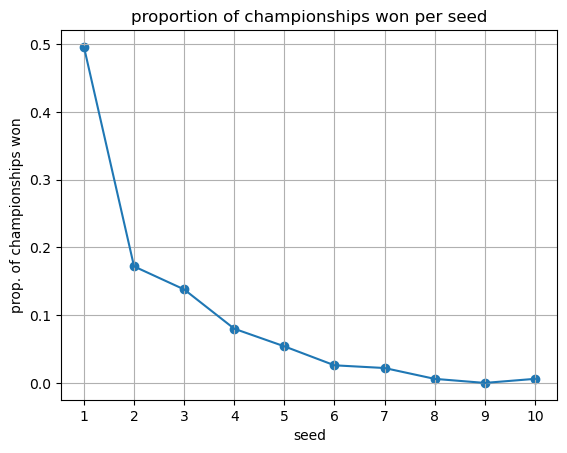

In [10]:
sim_seed_distributions(500, NBA_TEAMS, 0.5)

In [11]:
sim_seasons(250, NBA_TEAMS, {'Boston Celtics': 1, 'Memphis Grizzlies': 1, 'Dallas Mavericks':1})

  0%|          | 0/250 [00:00<?, ?it/s]

{'Boston Celtics': 50,
 'Brooklyn Nets': 7,
 'New York Knicks': 8,
 'Philadelphia 76ers': 5,
 'Toronto Raptors': 4,
 'Chicago Bulls': 3,
 'Cleveland Cavaliers': 4,
 'Detroit Pistons': 4,
 'Indiana Pacers': 2,
 'Milwaukee Bucks': 5,
 'Atlanta Hawks': 6,
 'Charlotte Hornets': 4,
 'Miami Heat': 6,
 'Orlando Magic': 3,
 'Washington Wizards': 2,
 'Denver Nuggets': 6,
 'Minnesota Timberwolves': 2,
 'Oklahoma City Thunder': 1,
 'Portland Trail Blazers': 5,
 'Utah Jazz': 2,
 'Golden State Warriors': 3,
 'Los Angeles Clippers': 0,
 'Los Angeles Lakers': 6,
 'Phoenix Suns': 6,
 'Sacramento Kings': 4,
 'Dallas Mavericks': 52,
 'Houston Rockets': 6,
 'Memphis Grizzlies': 34,
 'New Orleans Pelicans': 4,
 'San Antonio Spurs': 6}